In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
import os, sys
import time, glob
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.layers import *
from keras.models import Model
from keras.callbacks import *
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from LaneDataGenerator import LaneDataGenerator

%matplotlib inline

## DataGenerator

In [3]:
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 40, 120, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

data_gen = LaneDataGenerator(images_folder='./dataset/images',
                             labels_folder='./dataset/labels',
                             batch_size=4,
                             input_shape=INPUT_SHAPE)

### visualize data

steering_angle:  -0.5514462


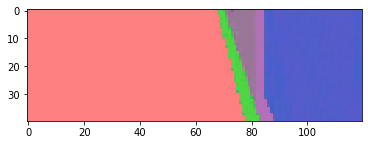

In [15]:
vis_im, vis_steering = data_gen[0]
plt.imshow(vis_im[0].astype(np.uint8))
print('steering_angle: ',vis_steering[0])

## Create model

In [ ]:
K.clear_session()

net_in = Input(shape = INPUT_SHAPE)
x = Lambda(lambda x: x/127.5 - 1.0)(net_in)
x = Conv2D(24, (5, 5), strides=(2, 2),padding="same", activation='elu')(x)  
x = Conv2D(36, (5, 5), strides=(2, 2),padding="same", activation='elu')(x)
x = Conv2D(48, (5, 5), strides=(2, 2),padding="same", activation='elu')(x)
x = Conv2D(64, (3, 3), padding="same",activation='elu')(x)   
x = Conv2D(64, (3, 3), padding="same",activation='elu')(x)

x = Dropout(0.3)(x)

x = Flatten()(x)

x = Dense(100, activation='elu')(x)
x = Dense(50, activation='elu')(x)
x = Dense(10, activation='elu')(x) 

net_out = Dense(1, name='net_out')(x)

model = Model(inputs=net_in, outputs=net_out)
model.summary()

## Train

In [ ]:
model.compile(loss='mse', optimizer=Adam(lr=0.001))

In [ ]:
filepath = ("./checkpoints/LaneDetector{epoch:03d}-{loss:.3f}.h5")
checkpoint = ModelCheckpoint(filepath, save_weights_only=False)
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, factor=0.5, verbose=1, mode='min')

history = model.fit_generator(
        data_gen, 
        steps_per_epoch=10,
        epochs=1000,        
        initial_epoch=0,
        callbacks=[checkpoint, reduce_lr],
        workers=2, use_multiprocessing=False)

## Convert to .tflite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model_file('checkpoints/LaneDetector277-0.002.h5') 
model = converter.convert()
file = open( 'model.tflite' , 'wb' ) 
file.write( model )
file.close()